## HW3: Decision Tree, AdaBoost and Random Forest
In hw3, you need to implement decision tree, adaboost and random forest by using only numpy, then train your implemented model by the provided dataset. TA will use the on-hold test label to evaluate your model performance.

Please note that only **NUMPY** can be used to implement your model, you will get no points by simply calling `sklearn.tree.DecisionTreeClassifier`

In [1]:
import numpy as np

## Question 1
Gini Index or Entropy is often used for measuring the “best” splitting of the data. Please compute the Entropy and Gini Index of provided data. Please use the formula from [page 5 of hw3 slides](https://docs.google.com/presentation/d/1kIe_-YZdemRMmr_3xDy-l0OS2EcLgDH7Uan14tlU5KE/edit#slide=id.gd542a5ff75_0_15)

In [2]:
# Copy and paste your implementations right here to check your result
# (Of course you can add your classes not written here)
def gini(sequence):
    pj = np.unique(sequence, return_counts=True)[1] / len(sequence)
    return 1 - np.sum(pj**2)

def entropy(sequence):
    pj = np.unique(sequence, return_counts=True)[1] / len(sequence)
    return - np.sum(np.dot(pj, np.log2(pj)))

In [3]:
# 1 = class 1,
# 2 = class 2
data = np.array([1,2,1,1,1,1,2,2,1,1,2])

In [4]:
print("Gini of data is ", gini(data))

Gini of data is  0.4628099173553719


In [5]:
print("Entropy of data is ", entropy(data))

Entropy of data is  0.9456603046006401


## Load data
It is a binary classifiation dataset that classify if price is high or not for a cell phone, the label is stored in `price_range` column.

In [6]:
import pandas as pd

train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('val.csv')
test_df = pd.read_csv('x_test.csv')
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)
val_df.head()

(1200, 21)
(300, 21)
(500, 20)


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,1883,1,2.7,1,6,1,30,0.5,95,2,...,531,791,3724,16,15,20,1,1,1,1
1,987,1,1.9,0,4,1,52,0.5,83,3,...,419,736,2757,17,12,15,1,1,0,1
2,1306,1,2.1,1,2,1,33,0.4,174,3,...,867,1258,2521,6,5,16,1,0,0,1
3,1611,1,0.5,1,11,0,3,0.6,98,3,...,303,714,1595,8,4,9,1,0,1,0
4,862,1,0.8,1,3,0,23,0.4,165,2,...,793,1758,278,16,3,11,0,0,1,0


In [7]:
features = []
for feature in train_df.columns:
    if feature != "price_range":
        features.append(feature)
print(features)

['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g', 'touch_screen', 'wifi']


In [8]:
x_train, y_train = train_df[features].to_numpy(), train_df["price_range"].to_numpy()
x_test, y_test = val_df[features].to_numpy(), val_df["price_range"].to_numpy()
demo = test_df.to_numpy()

## Question 2
Implement the Decision Tree algorithm (CART, Classification and Regression Trees) and trained the model by the given arguments, and print the accuracy score on the validation data. You should implement two arguments for the Decision Tree algorithm
1. **criterion**: The function to measure the quality of a split. Your model should support `gini` for the Gini impurity and `entropy` for the information gain. 
2. **max_depth**: The maximum depth of the tree. If `max_depth=None`, then nodes are expanded until all leaves are pure. `max_depth=1` equals to split data once


In [9]:
class Node:
    def __init__(self, class_index):
        self.class_index = class_index
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None

In [10]:
class DecisionTree():
    def __init__(self, criterion='gini', max_depth=None, max_features=-1):
        self.criterion = criterion
        self.max_depth = max_depth
        self.root = None
        self.num_features = None
        self.feature_weight = None
        self.max_features = max_features

    def gini(self, y_data, sample_weight):
        if len(y_data) == 0 or len(np.unique(y_data)) < 2:
            return 0
        pj = np.array([np.sum(sample_weight[y_data == 0]), np.sum(sample_weight[y_data == 1])]) / np.sum(sample_weight)
        return 1 - np.sum(pj**2)

    def entropy(self, y_data, sample_weight):
        if len(y_data) == 0 or len(np.unique(y_data)) < 2:
            return 0
        pj = np.array([np.sum(sample_weight[y_data == 0]), np.sum(sample_weight[y_data == 1])]) / np.sum(sample_weight)
        return - np.sum(np.dot(pj, np.log2(pj)))
        
    def SplitAttribute(self, x_data, y_data, sample_weight):
        feature_index = None
        threshold = None
        y_len = len(y_data)
        if len(np.unique(y_data)) <= 1:
            return None, None
        random_features = np.sort(np.random.permutation(np.arange(self.num_features))[:self.max_features])
        if self.criterion == 'gini':
            MinEnt = self.gini(y_data, sample_weight)
        else:
            MinEnt = self.entropy(y_data, sample_weight)
        z_data = np.concatenate((np.concatenate((x_data[:,random_features], y_data.reshape(y_len, 1)), axis=1), sample_weight.reshape(y_len, 1)), axis=1)
        for i in range(self.max_features):
            s_data = z_data[np.argsort(z_data[:, i])]
            x_temp, y_temp, sample_weight_temp = s_data[:,i], s_data[:,self.max_features], s_data[:,self.max_features+1]
            for j in range(1, y_len):
                if x_temp[j] == x_temp[j - 1]:
                    continue
                if self.criterion == 'gini':
                    e = (j * self.gini(y_temp[:j], sample_weight_temp[:j]) + (y_len - j) * self.gini(y_temp[j:], sample_weight_temp[j:])) / y_len
                else:
                    e = (j * self.entropy(y_temp[:j], sample_weight_temp[:j]) + (y_len - j) * self.entropy(y_temp[j:], sample_weight_temp[j:])) / y_len
                if e < MinEnt:
                    MinEnt = e
                    feature_index = random_features[i]
                    threshold = (x_temp[j] + x_temp[j - 1]) / 2
        return feature_index, threshold

    def GenerateTree(self, x_data, y_data, depth, sample_weight):
        p = np.unique(y_data, return_counts=True)
        class_index = p[0][np.argmax(p[1])]
        new_node = Node(class_index=class_index)
        if self.max_depth != None and depth >= self.max_depth:
            return new_node
        feature_index, threshold = self.SplitAttribute(x_data, y_data, sample_weight)
        if feature_index == None and threshold == None:
            return new_node
        self.feature_weight[feature_index] += 1
        new_node.feature_index = feature_index
        new_node.threshold = threshold
        left_index = x_data[:, feature_index] > threshold
        right_index = x_data[:, feature_index] <= threshold
        if len(left_index) <= 0 or len(right_index) <= 0:
            return new_node
        new_node.left = self.GenerateTree(x_data[left_index], y_data[left_index], depth + 1, sample_weight[left_index])
        new_node.right = self.GenerateTree(x_data[right_index], y_data[right_index], depth + 1, sample_weight[right_index])
        return new_node

    def fit(self, x_data, y_data, sample_weight=[]):
        self.num_features = x_data.shape[1]
        self.feature_weight = np.zeros(self.num_features)
        if self.max_features == -1:
            self.max_features = self.num_features
        if len(sample_weight) != len(y_data):
            sample_weight = np.ones(len(y_data))
        self.root = self.GenerateTree(x_data, y_data, 0, sample_weight)

    def predict(self, x_data):
        if self.root == None:
            #print("Why!")
            return np.zeros(x_data.shape[0])
        #print('OK')
        y_pred = []
        for feature in x_data:
            cur_node = self.root
            while cur_node.left and cur_node.right:
                if feature[cur_node.feature_index] > cur_node.threshold:
                    cur_node = cur_node.left
                else:
                    cur_node = cur_node.right
            y_pred.append(cur_node.class_index)
        return np.array(y_pred)


In [11]:
from sklearn.metrics import accuracy_score

### Question 2.1
Using `criterion=gini`, showing the accuracy score of validation data by `max_depth=3` and `max_depth=10`, respectively.


In [12]:
clf_depth3 = DecisionTree(criterion='gini', max_depth=3)
clf_depth10 = DecisionTree(criterion='gini', max_depth=10)
clf_depth3.fit(x_train, y_train)
clf_depth10.fit(x_train, y_train)


In [13]:
clf_depth3_pred = clf_depth3.predict(x_test)
clf_depth10_pred = clf_depth10.predict(x_test)
print(accuracy_score(y_test, clf_depth3_pred))
print(accuracy_score(y_test, clf_depth10_pred))

0.92
0.94


### Question 2.2
Using `max_depth=3`, showing the accuracy score of validation data by `criterion=gini` and `criterion=entropy`, respectively.


In [14]:
clf_gini = DecisionTree(criterion='gini', max_depth=3)
clf_entropy = DecisionTree(criterion='entropy', max_depth=3)
clf_gini.fit(x_train, y_train)
clf_entropy.fit(x_train, y_train)


In [15]:
clf_gini_pred = clf_gini.predict(x_test)
clf_entropy_pred = clf_entropy.predict(x_test)
print(accuracy_score(y_test, clf_gini_pred))
print(accuracy_score(y_test, clf_entropy_pred))

0.92
0.9333333333333333


- Note: Your decisition tree scores should over **0.9**. It may suffer from overfitting, if so, you can tune the hyperparameter such as `max_depth`
- Note: You should get the same results when re-building the model with the same arguments,  no need to prune the trees
- Hint: You can use the recursive method to build the nodes


## Question 3
Plot the [feature importance](https://sefiks.com/2020/04/06/feature-importance-in-decision-trees/) of your Decision Tree model. You can get the feature importance by counting the feature used for splitting data.

- You can simply plot the **counts of feature used** for building tree without normalize the importance. Take the figure below as example, outlook feature has been used for splitting for almost 50 times. Therefore, it has the largest importance

![image](https://i2.wp.com/sefiks.com/wp-content/uploads/2020/04/c45-fi-results.jpg?w=481&ssl=1)

Text(0.5, 1.0, 'Feature Importance')

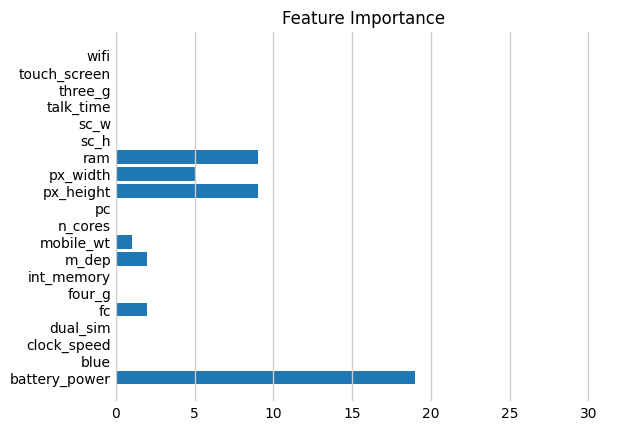

In [16]:
import matplotlib.pyplot as plt
plt.barh(features, clf_depth10.feature_weight)
for i in range(7):
    plt.axvline(x=i*5, linewidth=1, color='0.8')
plt.tick_params(axis='x', length=0)
plt.tick_params(axis='y', length=0)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.title('Feature Importance')

## Question 4
implement the AdaBooest algorithm by using the CART you just implemented from question 2 as base learner. You should implement one arguments for the AdaBooest.
1. **n_estimators**: The maximum number of estimators at which boosting is terminated

In [17]:
class AdaBoost():
    def __init__(self, n_estimators):
        self.n_estimators = n_estimators
        self.classifier = list()
        self.classifier_weight = list()
    def fit(self, x_data, y_data):
        #x_temp = x_data.copy()
        self.classifier = list()
        self.classifier_weight = list()
        D = np.ones(len(y_data)) / len(y_data)
        for i in range(self.n_estimators):
            self.classifier.append(DecisionTree(criterion='gini', max_depth=3))
            self.classifier[i].fit(x_data, y_data, D)
            y_pred = self.classifier[i].predict(x_data)
            #for j in range(len(y_pred)):
            #    if y_pred[j] != y_data[j]:
            #        x_temp[j] = np.dot(x_temp[j], 2.0)
            e = np.sum(D[y_pred != y_data])
            if e >= 1.0:
                self.classifier_weight.append(0)
            elif e <= 0.0:
                self.classifier_weight.append(300)
            else:
                self.classifier_weight.append(1/2 * np.log((1 - e) / e))
            tmp = y_data - y_pred
            tmp[tmp != 0] = -1
            tmp[tmp == 0] = 1
            D = D * np.exp(- self.classifier_weight[i] * tmp)
            D = D / np.sum(D)
            
    def predict(self, x_data):
        pred = np.zeros(len(x_data))
        for i in range(len(self.classifier)):
            y_pred = self.classifier[i].predict(x_data)
            y_pred[y_pred == 0] = -1
            pred = pred + self.classifier_weight[i] * y_pred
        pred = np.sign(pred)
        pred[pred <= 0] = 0
        return pred

### Question 4.1
Show the accuracy score of validation data by `n_estimators=10` and `n_estimators=100`, respectively.


In [18]:
clf_n_estimators10 = AdaBoost(n_estimators=10)
clf_n_estimators100 = AdaBoost(n_estimators=100)
clf_n_estimators10.fit(x_train, y_train)
clf_n_estimators100.fit(x_train, y_train)

In [19]:
clf_n_estimators10_pred = clf_n_estimators10.predict(x_test)
clf_n_estimators100_pred = clf_n_estimators100.predict(x_test)
print(accuracy_score(y_test, clf_n_estimators10_pred))
print(accuracy_score(y_test, clf_n_estimators100_pred))

0.95
0.95


## Question 5
implement the Random Forest algorithm by using the CART you just implemented from question 2. You should implement three arguments for the Random Forest.

1. **n_estimators**: The number of trees in the forest. 
2. **max_features**: The number of random select features to consider when looking for the best split
3. **bootstrap**: Whether bootstrap samples are used when building tree


In [20]:
class RandomForest():
    def __init__(self, n_estimators, max_features, boostrap=True, criterion='gini', max_depth=None):
        self.n_estimators = n_estimators
        self.max_features = int(max_features)
        self.boostrap = boostrap
        self.criterion = criterion
        self.max_depth = max_depth
        self.classifier = list()

    def fit(self, x_data, y_data, sample_weight=[]):
        for i in range(self.n_estimators):
            if self.boostrap:
                sample_index = np.random.choice(len(x_data), size=len(x_data), replace=True)
            else:
                sample_index = np.arange(len(x_data))
            self.classifier.append(DecisionTree(criterion=self.criterion, max_depth=self.max_depth, max_features=self.max_features))
            self.classifier[i].fit(x_data[sample_index], y_data[sample_index], sample_weight)

    def predict(self, x_data):
        y_pred = self.classifier[0].predict(x_data)
        ans = list()
        for i in range(1, len(self.classifier)):
            y_pred += self.classifier[i].predict(x_data)
        for i in range(len(y_pred)):
            ans.append(y_pred[i] > (self.n_estimators / 2))
        return np.array(ans)

### Question 5.1
Using `criterion=gini`, `max_depth=None`, `max_features=sqrt(n_features)`, showing the accuracy score of validation data by `n_estimators=10` and `n_estimators=100`, respectively.


In [21]:
clf_10tree = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]))
clf_100tree = RandomForest(n_estimators=100, max_features=np.sqrt(x_train.shape[1]))

In [22]:
clf_10tree.fit(x_train, y_train)
clf_100tree.fit(x_train, y_train)

In [23]:
clf_10tree_pred = clf_10tree.predict(x_test)
clf_100tree_pred = clf_100tree.predict(x_test)
print(accuracy_score(y_test, clf_10tree_pred))
print(accuracy_score(y_test, clf_100tree_pred))

0.9266666666666666
0.9566666666666667


### Question 5.2
Using `criterion=gini`, `max_depth=None`, `n_estimators=10`, showing the accuracy score of validation data by `max_features=sqrt(n_features)` and `max_features=n_features`, respectively.


In [24]:
clf_random_features = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]))
clf_all_features = RandomForest(n_estimators=10, max_features=x_train.shape[1])

In [25]:
clf_random_features.fit(x_train, y_train)
clf_all_features.fit(x_train, y_train)

In [26]:
clf_random_features_pred = clf_random_features.predict(x_test)
clf_all_features_pred = clf_all_features.predict(x_test)
print(accuracy_score(y_test, clf_random_features_pred))
print(accuracy_score(y_test, clf_all_features_pred))

0.9466666666666667
0.97


- Note: Use majority votes to get the final prediction, you may get slightly different results when re-building the random forest model

### Question 6. Train and tune your model on a real-world dataset
Try you best to get higher accuracy score of your model. After parameter tuning, you can train your model on the full dataset (train + val).
- Feature engineering
- Hyperparameter tuning
- Implement any other ensemble methods, such as gradient boosting. Please note that you **can not** call any package. Also, only ensemble method can be used. Neural network method is not allowed to used.

In [27]:
class MyModel():
    def __init__(self):
        self.n_estimators = 100
        self.max_features = 10
        self.boostrap = True
        self.criterion = 'entropy'
        self.max_depth = 8
        self.classifier = list()
        self.classifier_weight = list()

    def fit(self, x_data, y_data):
        x_temp = x_data.copy()
        D = np.ones(len(y_data)) / len(y_data)
        for i in range(self.n_estimators):
            if self.boostrap:
                sample_index = np.random.choice(len(x_data), size=len(x_data), replace=True)
            else:
                sample_index = np.arange(len(x_data))
            self.classifier.append(DecisionTree(criterion=self.criterion, max_depth=self.max_depth, max_features=self.max_features))
            self.classifier[i].fit(x_data[sample_index], y_data[sample_index], D[sample_index])
            y_pred = self.classifier[i].predict(x_temp)
            e = np.sum(D[y_pred != y_data])
            if e >= 1.0:
                self.classifier_weight.append(0)
            elif e <= 0.0:
                self.classifier_weight.append(300)
            else:
                self.classifier_weight.append(1/2 * np.log((1 - e) / e))
            tmp = y_data - y_pred
            tmp[tmp != 0] = -1
            tmp[tmp == 0] = 1
            D = D * np.exp(- self.classifier_weight[i] * tmp)
            D = D / np.sum(D)

    def predict(self, x_data):
        pred = np.zeros(len(x_data))
        for i in range(1, len(self.classifier)):
            y_pred = self.classifier[i].predict(x_data)
            y_pred[y_pred == 0] = -1
            pred += y_pred * self.classifier_weight[i]
        pred = np.sign(pred)
        pred[pred < 0] = 0
        return pred

In [28]:
my_model = MyModel()
my_model.fit(x_train, y_train)
y_pred = my_model.predict(x_test)
print(accuracy_score(y_test, y_pred))

0.9566666666666667


In [29]:
a_train = np.concatenate((x_train, x_test), axis=0)
b_train = np.concatenate((y_train, y_test), axis=0)

In [30]:
my_model = MyModel()
my_model.fit(a_train, b_train)
y_pred = my_model.predict(demo)

In [31]:
assert y_pred.shape == (500, )

## Supplementary
If you have trouble to implement this homework, TA strongly recommend watching [this video](https://www.youtube.com/watch?v=LDRbO9a6XPU), which explains Decision Tree model clearly. But don't copy code from any resources, try to finish this homework by yourself! 

### DO NOT MODIFY CODE BELOW

In [32]:
import pandas as pd
from sklearn.metrics import accuracy_score
y_test = pd.read_csv('y_test.csv')['price_range'].values

print('Test-set accuarcy score: ', accuracy_score(y_test, y_pred))

Test-set accuarcy score:  1.0


In [33]:
def discrete_checker(score, thres, clf, name, x_train, y_train, x_test, y_test):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    if accuracy_score(y_test, y_pred) - thres >= 0:
        return score
    else:
        print(f"{name} failed")
        return 0


def patient_checker(score, thres, CLS, kwargs, name,
                    x_train, y_train, x_test, y_test, patient=10):
    while patient > 0:
        patient -= 1
        clf = CLS(**kwargs)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        if accuracy_score(y_test, y_pred) - thres >= 0:
            return score
    print(f"{name} failed")
    print("Considering the randomness, we will check it manually")
    return 0


def load_dataset():
    file_url = "http://storage.googleapis.com/download.tensorflow.org/data/abalone_train.csv"
    df = pd.read_csv(
        file_url,
        names=["Length", "Diameter", "Height", "Whole weight", "Shucked weight",
               "Viscera weight", "Shell weight", "Age"]
    )

    df['Target'] = (df["Age"] > 15).astype(int)
    df = df.drop(labels=["Age"], axis="columns")

    train_idx = range(0, len(df), 10)
    test_idx = range(1, len(df), 20)

    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

    x_train = train_df.drop(labels=["Target"], axis="columns")
    feature_names = x_train.columns.values
    x_train = x_train.values
    y_train = train_df['Target'].values

    x_test = test_df.drop(labels=["Target"], axis="columns")
    x_test = x_test.values
    y_test = test_df['Target'].values
    return x_train, y_train, x_test, y_test, feature_names


score = 0

data = np.array([1, 2])
if abs(gini(data) - 0.5) < 1e-4:
    score += 2.5
else:
    print("gini test failed")

if abs(entropy(data) - 1) < 1e-4:
    score += 2.5
else:
    print("entropy test failed")

x_train, y_train, x_test, y_test, feature_names = load_dataset()

score += discrete_checker(5, 0.9337,
                          DecisionTree(criterion='gini', max_depth=3),
                          "DecisionTree(criterion='gini', max_depth=3)",
                          x_train, y_train, x_test, y_test
                          )

score += discrete_checker(2.5, 0.9036,
                          DecisionTree(criterion='gini', max_depth=10),
                          "DecisionTree(criterion='gini', max_depth=10)",
                          x_train, y_train, x_test, y_test
                          )

score += discrete_checker(2.5, 0.9096,
                          DecisionTree(criterion='entropy', max_depth=3),
                          "DecisionTree(criterion='entropy', max_depth=3)",
                          x_train, y_train, x_test, y_test
                          )

print("*** We will check your result for Question 3 manually *** (5 points)")

score += patient_checker(
    7.5, 0.91, AdaBoost, {"n_estimators": 10},
    "AdaBoost(n_estimators=10)",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    7.5, 0.87, AdaBoost, {"n_estimators": 100},
    "AdaBoost(n_estimators=100)",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.91, RandomForest,
    {"n_estimators": 10, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=10, max_features=sqrt(n_features))",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.91, RandomForest,
    {"n_estimators": 100, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=100, max_features=sqrt(n_features))",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.92, RandomForest,
    {"n_estimators": 10, "max_features": x_train.shape[1]},
    "RandomForest(n_estimators=10, max_features=n_features)",
    x_train, y_train, x_test, y_test
)

print("*** We will check your result for Question 6 manually *** (20 points)")
print("Approximate score range:", score, "~", score + 25)
print("*** This score is only for reference ***")


*** We will check your result for Question 3 manually *** (5 points)
*** We will check your result for Question 6 manually *** (20 points)
Approximate score range: 45.0 ~ 70.0
*** This score is only for reference ***
